In [73]:
from pyforest import *

In [74]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Imputing missing values and scaling values
from sklearn.preprocessing import Imputer, MinMaxScaler

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

In [75]:
# numpy and pandas for data manipulation
import pandas as pd
import numpy as np

# model used for feature importances
import lightgbm as lgb

# utility for early stopping with a validation set
from sklearn.model_selection import train_test_split

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# memory management
import gc

# utilities
from itertools import chain

class FeatureSelector():
    """
    Class for performing feature selection for machine learning or data preprocessing.
    
    Implements five different methods to identify features for removal 
    
        1. Find columns with a missing percentage greater than a specified threshold
        2. Find columns with a single unique value
        3. Find collinear variables with a correlation greater than a specified correlation coefficient
        4. Find features with 0.0 feature importance from a gradient boosting machine (gbm)
        5. Find low importance features that do not contribute to a specified cumulative feature importance from the gbm
        
    Parameters
    --------
        data : dataframe
            A dataset with observations in the rows and features in the columns
        labels : array or series, default = None
            Array of labels for training the machine learning model to find feature importances. These can be either binary labels
            (if task is 'classification') or continuous targets (if task is 'regression').
            If no labels are provided, then the feature importance based methods are not available.
        
    Attributes
    --------
    
    ops : dict
        Dictionary of operations run and features identified for removal
        
    missing_stats : dataframe
        The fraction of missing values for all features
    
    record_missing : dataframe
        The fraction of missing values for features with missing fraction above threshold
        
    unique_stats : dataframe
        Number of unique values for all features
    
    record_single_unique : dataframe
        Records the features that have a single unique value
        
    corr_matrix : dataframe
        All correlations between all features in the data
    
    record_collinear : dataframe
        Records the pairs of collinear variables with a correlation coefficient above the threshold
        
    feature_importances : dataframe
        All feature importances from the gradient boosting machine
    
    record_zero_importance : dataframe
        Records the zero importance features in the data according to the gbm
    
    record_low_importance : dataframe
        Records the lowest importance features not needed to reach the threshold of cumulative importance according to the gbm
    
    
    Notes
    --------
    
        - All 5 operations can be run with the `identify_all` method.
        - If using feature importances, one-hot encoding is used for categorical variables which creates new columns
    
    """
    
    def __init__(self, data, labels=None):
        
        # Dataset and optional training labels
        self.data = data
        self.labels = labels

        if labels is None:
            print('No labels provided. Feature importance based methods are not available.')
        
        self.base_features = list(data.columns)
        self.one_hot_features = None
        
        # Dataframes recording information about features to remove
        self.record_missing = None
        self.record_single_unique = None
        self.record_collinear = None
        self.record_zero_importance = None
        self.record_low_importance = None
        
        self.missing_stats = None
        self.unique_stats = None
        self.corr_matrix = None
        self.feature_importances = None
        
        # Dictionary to hold removal operations
        self.ops = {}
        
        self.one_hot_correlated = False
        
    def identify_missing(self, missing_threshold):
        """Find the features with a fraction of missing values above `missing_threshold`"""
        
        self.missing_threshold = missing_threshold

        # Calculate the fraction of missing in each column 
        missing_series = self.data.isnull().sum() / self.data.shape[0]
        self.missing_stats = pd.DataFrame(missing_series).rename(columns = {'index': 'feature', 0: 'missing_fraction'})

        # Sort with highest number of missing values on top
        self.missing_stats = self.missing_stats.sort_values('missing_fraction', ascending = False)

        # Find the columns with a missing percentage above the threshold
        record_missing = pd.DataFrame(missing_series[missing_series > missing_threshold]).reset_index().rename(columns = 
                                                                                                               {'index': 'feature', 
                                                                                                                0: 'missing_fraction'})

        to_drop = list(record_missing['feature'])

        self.record_missing = record_missing
        self.ops['missing'] = to_drop
        
        print('%d features with greater than %0.2f missing values.\n' % (len(self.ops['missing']), self.missing_threshold))
        
    def identify_single_unique(self):
        """Finds features with only a single unique value. NaNs do not count as a unique value. """

        # Calculate the unique counts in each column
        unique_counts = self.data.nunique()
        self.unique_stats = pd.DataFrame(unique_counts).rename(columns = {'index': 'feature', 0: 'nunique'})
        self.unique_stats = self.unique_stats.sort_values('nunique', ascending = True)
        
        # Find the columns with only one unique count
        record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(columns = {'index': 'feature', 
                                                                                                                0: 'nunique'})

        to_drop = list(record_single_unique['feature'])
    
        self.record_single_unique = record_single_unique
        self.ops['single_unique'] = to_drop
        
        print('%d features with a single unique value.\n' % len(self.ops['single_unique']))
    
    def identify_collinear(self, correlation_threshold, one_hot=False):
        """
        Finds collinear features based on the correlation coefficient between features. 
        For each pair of features with a correlation coefficient greather than `correlation_threshold`,
        only one of the pair is identified for removal. 
        Using code adapted from: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
        
        Parameters
        --------
        correlation_threshold : float between 0 and 1
            Value of the Pearson correlation cofficient for identifying correlation features
        one_hot : boolean, default = False
            Whether to one-hot encode the features before calculating the correlation coefficients
        """
        
        self.correlation_threshold = correlation_threshold
        self.one_hot_correlated = one_hot
        
         # Calculate the correlations between every column
        if one_hot:
            
            # One hot encoding
            features = pd.get_dummies(self.data)
            self.one_hot_features = [column for column in features.columns if column not in self.base_features]

            # Add one hot encoded data to original data
            self.data_all = pd.concat([features[self.one_hot_features], self.data], axis = 1)
            
            corr_matrix = pd.get_dummies(features).corr()

        else:
            corr_matrix = self.data.corr()
        
        self.corr_matrix = corr_matrix
    
        # Extract the upper triangle of the correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
        
        # Select the features with correlations above the threshold
        # Need to use the absolute value
        to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

        # Dataframe to hold correlated pairs
        record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

        # Iterate through the columns to drop to record pairs of correlated features
        for column in to_drop:

            # Find the correlated features
            corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

            # Find the correlated values
            corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
            drop_features = [column for _ in range(len(corr_features))]    

            # Record the information (need a temp df for now)
            temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': corr_features,
                                             'corr_value': corr_values})

            # Add to dataframe
            record_collinear = record_collinear.append(temp_df, ignore_index = True)

        self.record_collinear = record_collinear
        self.ops['collinear'] = to_drop
        
        print('%d features with a correlation magnitude greater than %0.2f.\n' % (len(self.ops['collinear']), self.correlation_threshold))

    def identify_zero_importance(self, task, eval_metric=None, 
                                 n_iterations=10, early_stopping = True):
        """
        
        Identify the features with zero importance according to a gradient boosting machine.
        The gbm can be trained with early stopping using a validation set to prevent overfitting. 
        The feature importances are averaged over `n_iterations` to reduce variance. 
        
        Uses the LightGBM implementation (http://lightgbm.readthedocs.io/en/latest/index.html)
        Parameters 
        --------
        eval_metric : string
            Evaluation metric to use for the gradient boosting machine for early stopping. Must be
            provided if `early_stopping` is True
        task : string
            The machine learning task, either 'classification' or 'regression'
        n_iterations : int, default = 10
            Number of iterations to train the gradient boosting machine
            
        early_stopping : boolean, default = True
            Whether or not to use early stopping with a validation set when training
        
        
        Notes
        --------
        
        - Features are one-hot encoded to handle the categorical variables before training.
        - The gbm is not optimized for any particular task and might need some hyperparameter tuning
        - Feature importances, including zero importance features, can change across runs
        """

        if early_stopping and eval_metric is None:
            raise ValueError("""eval metric must be provided with early stopping. Examples include "auc" for classification or
                             "l2" for regression.""")
            
        if self.labels is None:
            raise ValueError("No training labels provided.")
        
        # One hot encoding
        features = pd.get_dummies(self.data)
        self.one_hot_features = [column for column in features.columns if column not in self.base_features]

        # Add one hot encoded data to original data
        self.data_all = pd.concat([features[self.one_hot_features], self.data], axis = 1)

        # Extract feature names
        feature_names = list(features.columns)

        # Convert to np array
        features = np.array(features)
        labels = np.array(self.labels).reshape((-1, ))

        # Empty array for feature importances
        feature_importance_values = np.zeros(len(feature_names))
        
        print('Training Gradient Boosting Model\n')
        
        # Iterate through each fold
        for _ in range(n_iterations):

            if task == 'classification':
                model = lgb.LGBMClassifier(n_estimators=1000, learning_rate = 0.05, verbose = -1)

            elif task == 'regression':
                model = lgb.LGBMRegressor(n_estimators=1000, learning_rate = 0.05, verbose = -1)

            else:
                raise ValueError('Task must be either "classification" or "regression"')
                
            # If training using early stopping need a validation set
            if early_stopping:
                
                train_features, valid_features, train_labels, valid_labels = train_test_split(features, labels, test_size = 0.15)

                # Train the model with early stopping
                model.fit(train_features, train_labels, eval_metric = eval_metric,
                          eval_set = [(valid_features, valid_labels)],
                          early_stopping_rounds = 100, verbose = -1)
                
                # Clean up memory
                gc.enable()
                del train_features, train_labels, valid_features, valid_labels
                gc.collect()
                
            else:
                model.fit(features, labels)

            # Record the feature importances
            feature_importance_values += model.feature_importances_ / n_iterations

        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

        # Sort features according to importance
        feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

        # Normalize the feature importances to add up to one
        feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
        feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

        # Extract the features with zero importance
        record_zero_importance = feature_importances[feature_importances['importance'] == 0.0]
        
        to_drop = list(record_zero_importance['feature'])

        self.feature_importances = feature_importances
        self.record_zero_importance = record_zero_importance
        self.ops['zero_importance'] = to_drop
        
        print('\n%d features with zero importance after one-hot encoding.\n' % len(self.ops['zero_importance']))
    
    def identify_low_importance(self, cumulative_importance):
        """
        Finds the lowest importance features not needed to account for `cumulative_importance` fraction
        of the total feature importance from the gradient boosting machine. As an example, if cumulative
        importance is set to 0.95, this will retain only the most important features needed to 
        reach 95% of the total feature importance. The identified features are those not needed.
        Parameters
        --------
        cumulative_importance : float between 0 and 1
            The fraction of cumulative importance to account for 
        """

        self.cumulative_importance = cumulative_importance
        
        # The feature importances need to be calculated before running
        if self.feature_importances is None:
            raise NotImplementedError("""Feature importances have not yet been determined. 
                                         Call the `identify_zero_importance` method first.""")
            
        # Make sure most important features are on top
        self.feature_importances = self.feature_importances.sort_values('cumulative_importance')

        # Identify the features not needed to reach the cumulative_importance
        record_low_importance = self.feature_importances[self.feature_importances['cumulative_importance'] > cumulative_importance]

        to_drop = list(record_low_importance['feature'])

        self.record_low_importance = record_low_importance
        self.ops['low_importance'] = to_drop
    
        print('%d features required for cumulative importance of %0.2f after one hot encoding.' % (len(self.feature_importances) -
                                                                            len(self.record_low_importance), self.cumulative_importance))
        print('%d features do not contribute to cumulative importance of %0.2f.\n' % (len(self.ops['low_importance']),
                                                                                               self.cumulative_importance))
        
    def identify_all(self, selection_params):
        """
        Use all five of the methods to identify features to remove.
        
        Parameters
        --------
            
        selection_params : dict
           Parameters to use in the five feature selection methhods.
           Params must contain the keys ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']
        
        """
        
        # Check for all required parameters
        for param in ['missing_threshold', 'correlation_threshold', 'eval_metric', 'task', 'cumulative_importance']:
            if param not in selection_params.keys():
                raise ValueError('%s is a required parameter for this method.' % param)
        
        # Implement each of the five methods
        self.identify_missing(selection_params['missing_threshold'])
        self.identify_single_unique()
        self.identify_collinear(selection_params['correlation_threshold'])
        self.identify_zero_importance(task = selection_params['task'], eval_metric = selection_params['eval_metric'])
        self.identify_low_importance(selection_params['cumulative_importance'])
        
        # Find the number of features identified to drop
        self.all_identified = set(list(chain(*list(self.ops.values()))))
        self.n_identified = len(self.all_identified)
        
        print('%d total features out of %d identified for removal after one-hot encoding.\n' % (self.n_identified, 
                                                                                                  self.data_all.shape[1]))
        
    def check_removal(self, keep_one_hot=True):
        
        """Check the identified features before removal. Returns a list of the unique features identified."""
        
        self.all_identified = set(list(chain(*list(self.ops.values()))))
        print('Total of %d features identified for removal' % len(self.all_identified))
        
        if not keep_one_hot:
            if self.one_hot_features is None:
                print('Data has not been one-hot encoded')
            else:
                one_hot_to_remove = [x for x in self.one_hot_features if x not in self.all_identified]
                print('%d additional one-hot features can be removed' % len(one_hot_to_remove))
        
        return list(self.all_identified)
        
    
    def remove(self, methods, keep_one_hot = True):
        """
        Remove the features from the data according to the specified methods.
        
        Parameters
        --------
            methods : 'all' or list of methods
                If methods == 'all', any methods that have identified features will be used
                Otherwise, only the specified methods will be used.
                Can be one of ['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance']
            keep_one_hot : boolean, default = True
                Whether or not to keep one-hot encoded features
                
        Return
        --------
            data : dataframe
                Dataframe with identified features removed
                
        
        Notes 
        --------
            - If feature importances are used, the one-hot encoded columns will be added to the data (and then may be removed)
            - Check the features that will be removed before transforming data!
        
        """
        
        
        features_to_drop = []
      
        if methods == 'all':
            
            # Need to use one-hot encoded data as well
            data = self.data_all
                                          
            print('{} methods have been run\n'.format(list(self.ops.keys())))
            
            # Find the unique features to drop
            features_to_drop = set(list(chain(*list(self.ops.values()))))
            
        else:
            # Need to use one-hot encoded data as well
            if 'zero_importance' in methods or 'low_importance' in methods or self.one_hot_correlated:
                data = self.data_all
                
            else:
                data = self.data
                
            # Iterate through the specified methods
            for method in methods:
                
                # Check to make sure the method has been run
                if method not in self.ops.keys():
                    raise NotImplementedError('%s method has not been run' % method)
                    
                # Append the features identified for removal
                else:
                    features_to_drop.append(self.ops[method])
        
            # Find the unique features to drop
            features_to_drop = set(list(chain(*features_to_drop)))
            
        features_to_drop = list(features_to_drop)
            
        if not keep_one_hot:
            
            if self.one_hot_features is None:
                print('Data has not been one-hot encoded')
            else:
                             
                features_to_drop = list(set(features_to_drop) | set(self.one_hot_features))
       
        # Remove the features and return the data
        data = data.drop(columns = features_to_drop)
        self.removed_features = features_to_drop
        
        if not keep_one_hot:
        	print('Removed %d features including one-hot features.' % len(features_to_drop))
        else:
        	print('Removed %d features.' % len(features_to_drop))
        
        return data
    
    def plot_missing(self):
        """Histogram of missing fraction in each feature"""
        if self.record_missing is None:
            raise NotImplementedError("Missing values have not been calculated. Run `identify_missing`")
        
        self.reset_plot()
        
        # Histogram of missing values
        plt.style.use('seaborn-white')
        plt.figure(figsize = (7, 5))
        plt.hist(self.missing_stats['missing_fraction'], bins = np.linspace(0, 1, 11), edgecolor = 'k', color = 'red', linewidth = 1.5)
        plt.xticks(np.linspace(0, 1, 11));
        plt.xlabel('Missing Fraction', size = 14); plt.ylabel('Count of Features', size = 14); 
        plt.title("Fraction of Missing Values Histogram", size = 16);
        
    
    def plot_unique(self):
        """Histogram of number of unique values in each feature"""
        if self.record_single_unique is None:
            raise NotImplementedError('Unique values have not been calculated. Run `identify_single_unique`')
        
        self.reset_plot()

        # Histogram of number of unique values
        self.unique_stats.plot.hist(edgecolor = 'k', figsize = (7, 5))
        plt.ylabel('Frequency', size = 14); plt.xlabel('Unique Values', size = 14); 
        plt.title('Number of Unique Values Histogram', size = 16);
        
    
    def plot_collinear(self, plot_all = False):
        """
        Heatmap of the correlation values. If plot_all = True plots all the correlations otherwise
        plots only those features that have a correlation above the threshold
        
        Notes
        --------
            - Not all of the plotted correlations are above the threshold because this plots
            all the variables that have been idenfitied as having even one correlation above the threshold
            - The features on the x-axis are those that will be removed. The features on the y-axis
            are the correlated features with those on the x-axis
        
        Code adapted from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
        """
        
        if self.record_collinear is None:
            raise NotImplementedError('Collinear features have not been idenfitied. Run `identify_collinear`.')
        
        if plot_all:
        	corr_matrix_plot = self.corr_matrix
        	title = 'All Correlations'
        
        else:
	        # Identify the correlations that were above the threshold
	        # columns (x-axis) are features to drop and rows (y_axis) are correlated pairs
	        corr_matrix_plot = self.corr_matrix.loc[list(set(self.record_collinear['corr_feature'])), 
	                                                list(set(self.record_collinear['drop_feature']))]

	        title = "Correlations Above Threshold"

       
        f, ax = plt.subplots(figsize=(10, 8))
        
        # Diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)

        # Draw the heatmap with a color bar
        sns.heatmap(corr_matrix_plot, cmap=cmap, center=0,
                    linewidths=.25, cbar_kws={"shrink": 0.6})

        # Set the ylabels 
        ax.set_yticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[0]))])
        ax.set_yticklabels(list(corr_matrix_plot.index), size = int(160 / corr_matrix_plot.shape[0]));

        # Set the xlabels 
        ax.set_xticks([x + 0.5 for x in list(range(corr_matrix_plot.shape[1]))])
        ax.set_xticklabels(list(corr_matrix_plot.columns), size = int(160 / corr_matrix_plot.shape[1]));
        plt.title(title, size = 14)
        
    def plot_feature_importances(self, plot_n = 15, threshold = None):
        """
        Plots `plot_n` most important features and the cumulative importance of features.
        If `threshold` is provided, prints the number of features needed to reach `threshold` cumulative importance.
        Parameters
        --------
        
        plot_n : int, default = 15
            Number of most important features to plot. Defaults to 15 or the maximum number of features whichever is smaller
        
        threshold : float, between 0 and 1 default = None
            Threshold for printing information about cumulative importances
        """
        
        if self.record_zero_importance is None:
            raise NotImplementedError('Feature importances have not been determined. Run `idenfity_zero_importance`')
            
        # Need to adjust number of features if greater than the features in the data
        if plot_n > self.feature_importances.shape[0]:
            plot_n = self.feature_importances.shape[0] - 1

        self.reset_plot()
        
        # Make a horizontal bar chart of feature importances
        plt.figure(figsize = (10, 6))
        ax = plt.subplot()

        # Need to reverse the index to plot most important on top
        # There might be a more efficient method to accomplish this
        ax.barh(list(reversed(list(self.feature_importances.index[:plot_n]))), 
                self.feature_importances['normalized_importance'][:plot_n], 
                align = 'center', edgecolor = 'k')

        # Set the yticks and labels
        ax.set_yticks(list(reversed(list(self.feature_importances.index[:plot_n]))))
        ax.set_yticklabels(self.feature_importances['feature'][:plot_n], size = 12)

        # Plot labeling
        plt.xlabel('Normalized Importance', size = 16); plt.title('Feature Importances', size = 18)
        plt.show()

        # Cumulative importance plot
        plt.figure(figsize = (6, 4))
        plt.plot(list(range(1, len(self.feature_importances) + 1)), self.feature_importances['cumulative_importance'], 'r-')
        plt.xlabel('Number of Features', size = 14); plt.ylabel('Cumulative Importance', size = 14); 
        plt.title('Cumulative Feature Importance', size = 16);

        if threshold:

            # Index of minimum number of features needed for cumulative importance threshold
            # np.where returns the index so need to add 1 to have correct number
            importance_index = np.min(np.where(self.feature_importances['cumulative_importance'] > threshold))
            plt.vlines(x = importance_index + 1, ymin = 0, ymax = 1, linestyles='--', colors = 'blue')
            plt.show();

            print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))

    def reset_plot(self):
        plt.rcParams = plt.rcParamsDefault

In [76]:
# Read in data into a dataframe 
data = pd.read_csv(r"C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\LR - Energy Rating\Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv")

# Display top of dataframe
data.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,10017,675,3 AVENUE,Manhattan,289356.0,Office,Office,Office,293447,Not Available,Not Available,Not Available,Not Available,1963,2,100,Whole Building,Not Available,Not Available,305.6,303.1,37.8,Not Available,614.2,Not Available,Not Available,Not Available,Not Available,Not Available,5.15506751E7,Not Available,Not Available,38139374.2,1.10827705E7,6962.2,0,6962.2,762051,Not Available,Not Available,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,10032,180,FT WASHINGTON AVENUE,Manhattan,3693539.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),3889181,Not Available,Not Available,Not Available,Not Available,1969,12,100,Whole Building,Whole Building,55,229.8,228.8,24.8,2.4,401.1,Not Available,1.96248472E7,Not Available,Not Available,Not Available,-3.914148026E8,933073441,9330734.4,332365924,9.62613121E7,55870.4,51016.4,4854.1,3889181,Not Available,Not Available,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0,Washington Heights South ...
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,10032,3975,BROADWAY,Manhattan,152765.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),231342,Not Available,Not Available,Not Available,Not Available,1924,1,100,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,0,0,0,231342,Not Available,Not Available,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0,Washington Heights South ...
3,4,4778267,Herbert Irving Pavilion & Millstein Hospital,28400,NYP Columbia (West Campus),1021390001,1-02139-0001,1087281; 1076746,161 Fort Washington Ave,177 Fort Washington Ave,10032,161,FT WASHINGTON AVENUE,Manhattan,891040.0,Hos

In [77]:
# See the column data types and non-missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 60 columns):
Order                                                         11746 non-null int64
Property Id                                                   11746 non-null int64
Property Name                                                 11746 non-null object
Parent Property Id                                            11746 non-null object
Parent Property Name                                          11746 non-null object
BBL - 10 digits                                               11735 non-null object
NYC Borough, Block and Lot (BBL) self-reported                11746 non-null object
NYC Building Identification Number (BIN)                      11746 non-null object
Address 1 (self-reported)                                     11746 non-null object
Address 2                                                     11746 non-null object
Postal Code                                          

In [78]:
# Replace all occurrences of Not Available with numpy not a number
data = data.replace({'Not Available': np.nan})

# Iterate through the columns
for col in list(data.columns):
    # Select columns that should be numeric
    if ('ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in 
        col or 'therms' in col or 'gal' in col or 'Score' in col):
        # Convert the data type to float
        data[col] = data[col].astype(float)

In [79]:
# Statistics for each column
data.describe()

,Order,Property Id,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Latitude,Longitude,Community Board,Council District,Census Tract
count,11746.000000,1.174600e+04,1.162800e+04,1.174400e+04,3741.000000,1484.000000,11746.000000,11746.000000,11746.000000,9642.000000,11583.000000,10281.000000,10959.000000,9783.000000,10281.000000,9.000000e+00,2.581000e+03,1.321000e+03,5.940000e+02,1.600000e+01,9.360000e+02,1.030400e+04,9.784000e+03,1.150200e+04,1.096000e+04,1.167200e+04,1.166300e+04,1.168100e+04,1.174600e+04,7.762000e+03,7762.000000,11583.000000,9483.000000,9483.000000,9483.000000,9483.000000,9483.000000
mean,7185.759578,3.642958e+06,1.732695e+05,1.605524e+05,22778.682010,12016.825270,1948.738379,1.289971,98.762557,59.854594,280.071484,309.747466,11.072643,1.901441,417.915709,3.395398e+06,3.186882e+06,5.294367e+06,2.429105e+06,1.193594e+06,2.868907e+08,5.048545e+07,5.364578e+05,5.965472e+06,1.768752e+06,4.553657e+03,2.477937e+03,2.076339e+03,1.673739e+05,1.591798e+04,136.172432,385.908029,40.754379,-73.957057,7.140673,15.771275,4977.596647
std,4323.859984,1.049070e+06,3.367055e+05,3.095746e+05,55094.441422,27959.755486,30.576386,4.017484,7.501603,29.993586,8607.178877,9784.731207,127.733868,97.204587,10530.524339,2.213237e+06,5.497154e+06,5.881863e+06,4.442946e+06,3.558178e+06,3.124603e+09,3.914719e+09,4.022606e+07,3.154430e+07,9.389154e+06,2.041639e+05,1.954498e+05,5.931295e+04,3.189238e+05,1.529524e+05,1730.726938,9312.736225,0.080120,0.046337,3.954129,15.674375,13520.422990
min,1.000000,7.365000e+03,5.002800e+04,5.400000e+01,0.000000,0.000000,1600.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.085973e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.690797e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.313430e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,40.516065,-74.243582,1.000000,1.000000,1.000000
25%,3428.250000,2.747222e+06,6.524000e+04,6.520100e+04,4000.000000,1720.750000,1927.000000,1.000000,100.000000,37.000000,61.800000,65.100000,3.800000,0.100000,103.500000,1.663594e+06,2.550378e+05,2.128213e+06,0.000000e+00,5.698020e+04,4.320254e+06,1.098251e+06,1.176952e+04,1.043673e+06,3.019974e+05,3.287000e+02,1.474500e+02,9.480000e+01,6.699400e+04,2.595400e+03,27.150000,99.400000,40.707226,-73.984662,4.000000,4.000000,100.000000
50%,6986.500000,3.236404e+06,9.313850e+04,9.132400e+04,8654.000000,5000.000000,1941.000000,1.000000,100.000000,65.000000,78.500000,82.500000,5.300000,0.500000,129.400000,4.328815e+06,1.380138e+06,4.312984e+06,0.000000e+00,2.070020e+05,9.931240e+06,4.103962e+06,4.445525e+04,1.855196e+06,5.416312e+05,5.002500e+02,2.726000e+02,1.718000e+02,9.408000e+04,4.692500e+03,45.095000,124.900000,40.759130,-73.962810,7.000000,9.000000,201.000000
75%,11054.500000,4.409092e+06,1.596140e+05,1.532550e+05,20000.000000,12000.000000,1966.000000,1.000000,100.000000,85.000000,97.600000,102.500000,9.200000,0.700000,167.200000,4.938947e+06,4.445808e+06,6.514520e+06,4.293825e+06,2.918332e+0

In [80]:
data.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,NaN,10017,675,3 AVENUE,Manhattan,289356.0,Office,Office,Office,293447.0,NaN,NaN,NaN,NaN,1963,2,100,Whole Building,NaN,NaN,305.6,303.1,37.8,NaN,614.2,NaN,NaN,NaN,NaN,NaN,51550675.1,NaN,NaN,38139374.2,11082770.5,6962.2,0.0,6962.2,762051.0,NaN,NaN,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,NaN,10032,180,FT WASHINGTON AVENUE,Manhattan,3693539.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),3889181.0,NaN,NaN,NaN,NaN,1969,12,100,Whole Building,Whole Building,55.0,229.8,228.8,24.8,2.4,401.1,NaN,19624847.2,NaN,NaN,NaN,-391414802.6,933073441.0,9330734.4,332365924.0,96261312.1,55870.4,51016.4,4854.1,3889181.0,NaN,NaN,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0,Washington Heights South ...
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,NaN,10032,3975,BROADWAY,Manhattan,152765.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),231342.0,NaN,NaN,NaN,NaN,1924,1,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,231342.0,NaN,NaN,NaN,04/27/2017 11:23:27 AM,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0,Washington Heights South ...
3,4,4778267,Herbert Irving Pavilion & Millstein Hospital,28400,NYP Columbia (West Campus),1021390001,1-02139-0001,1087281; 1076746,161 Fort Washington Ave,177 Fort Washington Ave,10032,161,FT WASHINGTON AVENUE,Manhattan,891040.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),1305748.0,NaN,NaN,NaN,NaN,1971,1,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1305748.0,NaN,NaN,NaN,04/27/2017 11:23:27 AM,No,In Compliance,40.840746,-73.942854,12.0,10.0,255.0,Washington Heights South ...
4,5,4778288,Neuro Institute,28400,NYP Columbia (West Campus),1021390085,1-02139-0085,1063403,710 West 168th Street,NaN,10032,193,FT WASHINGTON AVENUE,Manhattan,2114

In [81]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [82]:
missing_values_table(data)

Your selected dataframe has 60 columns.
There are 46 columns that have missing values.


,Missing Values,% of Total Values
Fuel Oil #1 Use (kBtu),11737,99.9
Diesel #2 Use (kBtu),11730,99.9
Address 2,11539,98.2
Fuel Oil #5 & 6 Use (kBtu),11152,94.9
District Steam Use (kBtu),10810,92.0
Fuel Oil #4 Use (kBtu),10425,88.8
3rd Largest Property Use Type - Gross Floor Area (ft²),10262,87.4
3rd Largest Property Use Type,10262,87.4
Fuel Oil #2 Use (kBtu),9165,78.0
2nd Largest Property Use Type,8005,68.2


In [83]:
# Get the columns with > 50% missing
missing_df = missing_values_table(data);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))

Your selected dataframe has 60 columns.
There are 46 columns that have missing values.
We will remove 11 columns.


In [84]:
# Drop the columns
data = data.drop(columns = list(missing_columns))

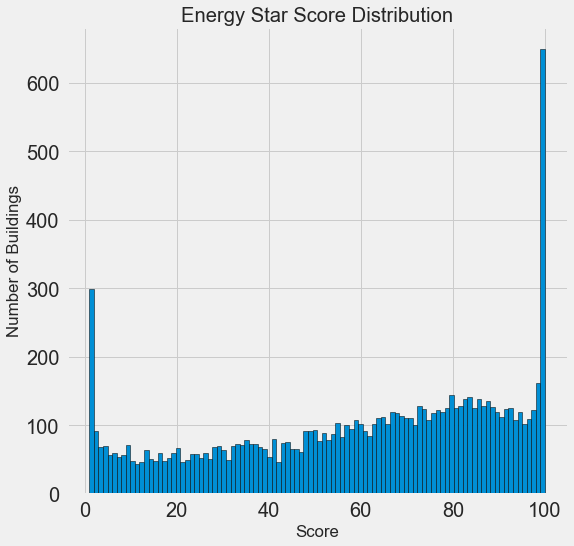

In [85]:
figsize(8, 8)

# Rename the score 
data = data.rename(columns = {'ENERGY STAR Score': 'score'})

# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(data['score'].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel('Score'); 
plt.ylabel('Number of Buildings'); 
plt.title('Energy Star Score Distribution');

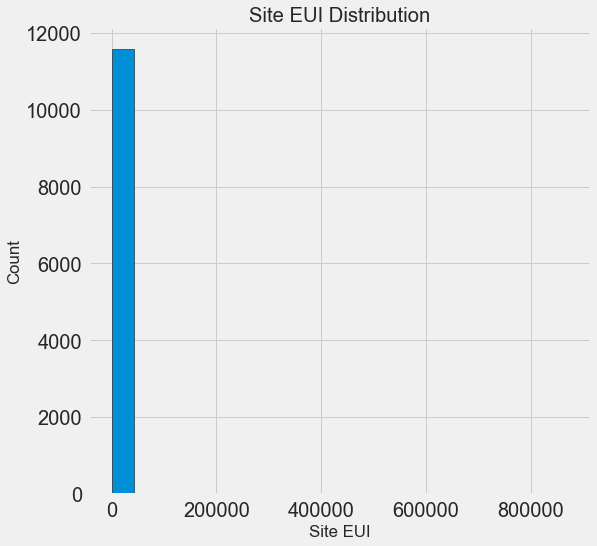

In [86]:
# Histogram Plot of Site EUI
figsize(8, 8)
plt.hist(data['Site EUI (kBtu/ft²)'].dropna(), bins = 20, edgecolor = 'black');
plt.xlabel('Site EUI'); 
plt.ylabel('Count'); 
plt.title('Site EUI Distribution');

In [87]:
data['Site EUI (kBtu/ft²)'].describe()

count     11583.000000
mean        280.071484
std        8607.178877
min           0.000000
25%          61.800000
50%          78.500000
75%          97.600000
max      869265.000000
Name: Site EUI (kBtu/ft²), dtype: float64

In [88]:
data['Site EUI (kBtu/ft²)'].dropna().sort_values().tail(10)

3173     51328.8
3170     51831.2
3383     78360.1
8269     84969.6
3263     95560.2
8268    103562.7
8174    112173.6
3898    126307.4
7       143974.4
8068    869265.0
Name: Site EUI (kBtu/ft²), dtype: float64

In [89]:
data.loc[data['Site EUI (kBtu/ft²)'] == 869265, :]

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
8068,9984,4414323,234 Skillman,Not Applicable: Standalone Property,Not Applicable: Standalone Property,3028937502,3028937502,"3390250 , 3338313",234 Skillman avenue,11211,234,SKILLMAN AVENUE,Brooklyn,61811.0,Multifamily Housing,Multifamily Housing,Multifamily Housing,56900.0,2004,1,90,Whole Building,NaN,1.0,869265.0,939329.0,9.9,9393.0,986366.0,4.945919e+10,534458968.8,1983655.6,563239.6,2627199.1,2627015.0,184.1,56900.0,2547.9,44.78,912801.1,05/01/2017 11:34:14 PM,NaN,In Compliance,40.716233,-73.94141,1.0,34.0,477.0,East Williamsburg ...


In [90]:
# Calculate first and third quartile
first_quartile = data['Site EUI (kBtu/ft²)'].describe()['25%']
third_quartile = data['Site EUI (kBtu/ft²)'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
data = data[(data['Site EUI (kBtu/ft²)'] > (first_quartile - 3 * iqr)) &
            (data['Site EUI (kBtu/ft²)'] < (third_quartile + 3 * iqr))]

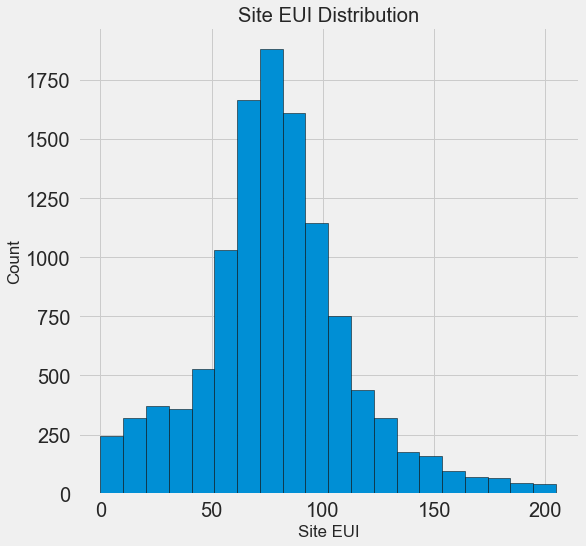

In [91]:
# Histogram Plot of Site EUI
figsize(8, 8)
plt.hist(data['Site EUI (kBtu/ft²)'].dropna(), bins = 20, edgecolor = 'black');
plt.xlabel('Site EUI'); 
plt.ylabel('Count'); 
plt.title('Site EUI Distribution');

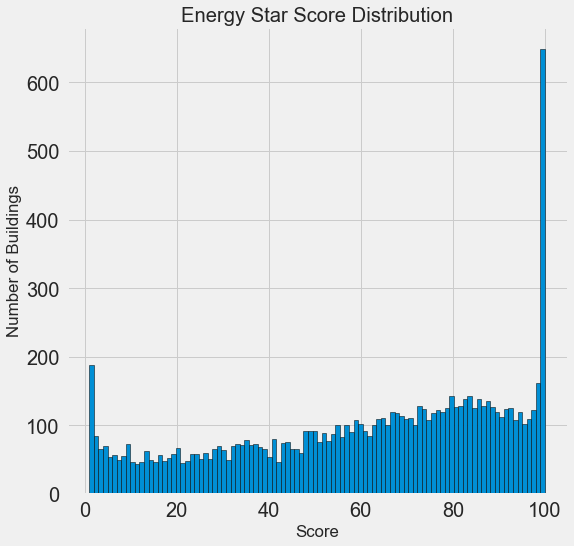

In [92]:
figsize(8, 8)

# Rename the score 
data = data.rename(columns = {'ENERGY STAR Score': 'score'})

# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(data['score'].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel('Score'); plt.ylabel('Number of Buildings'); 
plt.title('Energy Star Score Distribution');

In [93]:
# Create a list of buildings with more than 100 measurements
types = data.dropna(subset=['score'])
types = types['Largest Property Use Type'].value_counts()
types = list(types[types.values > 100].index)

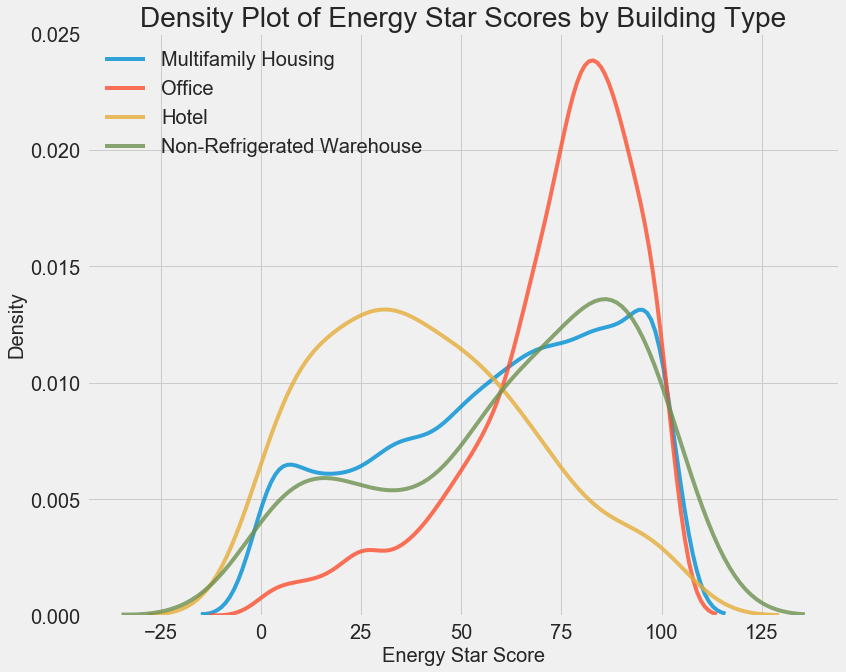

In [94]:
# Plot of distribution of scores for building categories
figsize(12, 10)

# Plot each building
for b_type in types:
    # Select the building type
    subset = data[data['Largest Property Use Type'] == b_type]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['score'].dropna(),
               label = b_type, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Energy Star Scores by Building Type', size = 28);

In [95]:
# Create a list of boroughs with more than 100 observations
boroughs = data.dropna(subset=['score'])
boroughs = boroughs['Borough'].value_counts()
boroughs = list(boroughs[boroughs.values > 100].index)

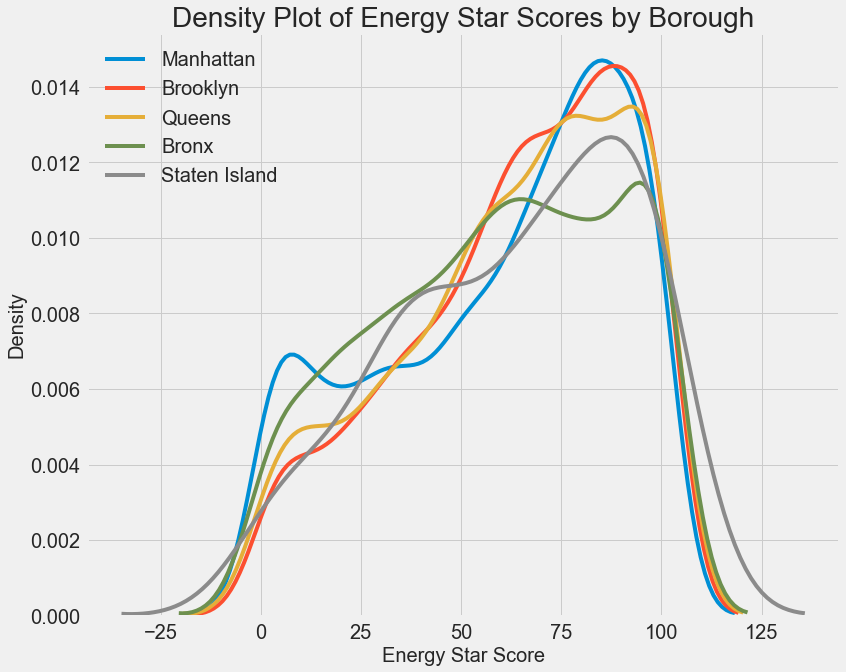

In [96]:
# Plot of distribution of scores for boroughs
figsize(12, 10)

# Plot each borough distribution of scores
for borough in boroughs:
    # Select the building type
    subset = data[data['Borough'] == borough]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['score'].dropna(),
               label = borough);
    
# label the plot
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Energy Star Scores by Borough', size = 28);

In [97]:
# Find all correlations and sort 
correlations_data = data.corr()['score'].sort_values()

# Print the most negative correlations
print(correlations_data.head(15), '\n')

# Print the most positive correlations
print(correlations_data.tail(15))

Site EUI (kBtu/ft²)                                          -0.723864
Weather Normalized Site EUI (kBtu/ft²)                       -0.713993
Weather Normalized Source EUI (kBtu/ft²)                     -0.645542
Source EUI (kBtu/ft²)                                        -0.641037
Weather Normalized Site Electricity Intensity (kWh/ft²)      -0.358394
Weather Normalized Site Natural Gas Intensity (therms/ft²)   -0.346046
Direct GHG Emissions (Metric Tons CO2e)                      -0.147792
Weather Normalized Site Natural Gas Use (therms)             -0.135211
Natural Gas Use (kBtu)                                       -0.133648
Year Built                                                   -0.121249
Total GHG Emissions (Metric Tons CO2e)                       -0.113136
Electricity Use - Grid Purchase (kBtu)                       -0.050639
Weather Normalized Site Electricity (kWh)                    -0.048207
Latitude                                                     -0.048196
Proper

In [98]:
# Select the numeric columns
numeric_subset = data.select_dtypes('number')

# Create columns with square root and log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'score':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Select the categorical columns
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Drop buildings without an energy star score
features = features.dropna(subset = ['score'])

# Find correlations with the score 
correlations = features.corr()['score'].dropna().sort_values()

C:\Users\gaurav.singh.rawal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\Users\gaurav.singh.rawal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
C:\Users\gaurav.singh.rawal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [99]:
correlations.head(15)

Site EUI (kBtu/ft²)                                            -0.723864
Weather Normalized Site EUI (kBtu/ft²)                         -0.713993
sqrt_Site EUI (kBtu/ft²)                                       -0.699817
sqrt_Weather Normalized Site EUI (kBtu/ft²)                    -0.689019
sqrt_Weather Normalized Source EUI (kBtu/ft²)                  -0.671044
sqrt_Source EUI (kBtu/ft²)                                     -0.669396
Weather Normalized Source EUI (kBtu/ft²)                       -0.645542
Source EUI (kBtu/ft²)                                          -0.641037
log_Source EUI (kBtu/ft²)                                      -0.622892
log_Weather Normalized Source EUI (kBtu/ft²)                   -0.620329
log_Site EUI (kBtu/ft²)                                        -0.612039
log_Weather Normalized Site EUI (kBtu/ft²)                     -0.601332
log_Weather Normalized Site Electricity Intensity (kWh/ft²)    -0.424246
sqrt_Weather Normalized Site Electricity Intensity 

In [100]:
correlations.tail(15)

sqrt_Order                                                         0.028662
Borough_Queens                                                     0.029545
Largest Property Use Type_Supermarket/Grocery Store                0.030038
Largest Property Use Type_Residence Hall/Dormitory                 0.035407
Order                                                              0.036827
Largest Property Use Type_Hospital (General Medical & Surgical)    0.048410
Borough_Brooklyn                                                   0.050486
log_Community Board                                                0.055495
Community Board                                                    0.056612
sqrt_Community Board                                               0.058029
sqrt_Council District                                              0.060623
log_Council District                                               0.061101
Council District                                                   0.061639
Largest Prop

In [101]:
transformed_df=features.drop(correlations[(correlations<0.4) & (correlations>(-0.5))].index,axis=1)

In [102]:
transformed_df.head()

,score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Source EUI (kBtu/ft²),sqrt_Site EUI (kBtu/ft²),log_Site EUI (kBtu/ft²),sqrt_Weather Normalized Site EUI (kBtu/ft²),log_Weather Normalized Site EUI (kBtu/ft²),sqrt_Weather Normalized Source EUI (kBtu/ft²),log_Weather Normalized Source EUI (kBtu/ft²),sqrt_Source EUI (kBtu/ft²),log_Source EUI (kBtu/ft²),sqrt_Longitude,log_Longitude,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Library,Largest Property Use Type_Mailing Center/Post Office,Largest Property Use Type_Manufacturing/Industrial Plant,Largest Property Use Type_Movie Theater,Largest Property Use Type_Museum,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient
12,93.0,32.0,NaN,NaN,87.9,5.656854,3.465736,NaN,NaN,NaN,NaN,9.375500,4.476200,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18,72.0,76.2,79.9,106.2,103.3,8.729261,4.333361,8.938680,4.380776,10.305338,4.665324,10.163661,4.637637,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19,67.0,75.7,79.0,109.1,106.6,8.700575,4.326778,8.888194,4.369448,10.445095,4.692265,10.324728,4.669084,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20,80.0,77.1,82.7,102.8,97.7,8.780661,4.345103,9.093954,4.415220,10.139033,4.632785,9.884331,4.581902,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21,100.0,68.0,NaN,NaN,115.6,8.246211,4.219508,NaN,NaN,NaN,NaN,10.751744,4.750136,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [103]:
missing_values_table(transformed_df)

Your selected dataframe has 44 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
sqrt_Longitude,9461,100.0
log_Longitude,9461,100.0
Weather Normalized Site EUI (kBtu/ft²),1066,11.3
Weather Normalized Source EUI (kBtu/ft²),1066,11.3
sqrt_Weather Normalized Site EUI (kBtu/ft²),1066,11.3
log_Weather Normalized Site EUI (kBtu/ft²),1066,11.3
sqrt_Weather Normalized Source EUI (kBtu/ft²),1066,11.3
log_Weather Normalized Source EUI (kBtu/ft²),1066,11.3


In [104]:
transformed_df=transformed_df.drop(['sqrt_Longitude','log_Longitude'],axis=1)

In [105]:
numeric_df=transformed_df.select_dtypes('float64')
numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9461 entries, 12 to 11745
Data columns (total 13 columns):
score                                            9461 non-null float64
Site EUI (kBtu/ft²)                              9461 non-null float64
Weather Normalized Site EUI (kBtu/ft²)           8395 non-null float64
Weather Normalized Source EUI (kBtu/ft²)         8395 non-null float64
Source EUI (kBtu/ft²)                            9461 non-null float64
sqrt_Site EUI (kBtu/ft²)                         9461 non-null float64
log_Site EUI (kBtu/ft²)                          9461 non-null float64
sqrt_Weather Normalized Site EUI (kBtu/ft²)      8395 non-null float64
log_Weather Normalized Site EUI (kBtu/ft²)       8395 non-null float64
sqrt_Weather Normalized Source EUI (kBtu/ft²)    8395 non-null float64
log_Weather Normalized Source EUI (kBtu/ft²)     8395 non-null float64
sqrt_Source EUI (kBtu/ft²)                       9461 non-null float64
log_Source EUI (kBtu/ft²)              

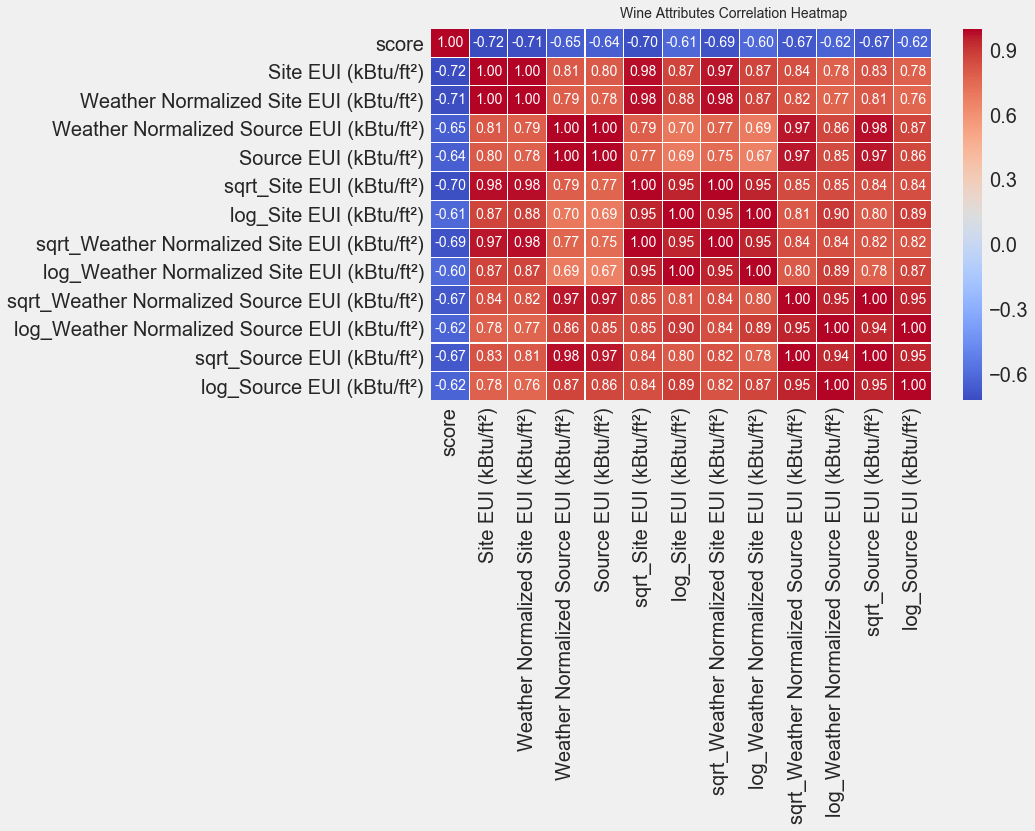

In [106]:
# Correlation Matrix Heatmap 
f, ax = plt.subplots(figsize=(10, 6)) 
corr = numeric_df.corr() 
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05) 
f.subplots_adjust(top=0.93) 
t= f.suptitle('Wine Attributes Correlation Heatmap', fontsize=14)

In [107]:
# Rename columns 
transformed_df = transformed_df.rename(columns = {'Site EUI (kBtu/ft²)':'Site EUI','Weather Normalized Source EUI (kBtu/ft²)': 'Weather Source EUI','Weather Normalized Site EUI (kBtu/ft²)': 'Weather Site EUI'})

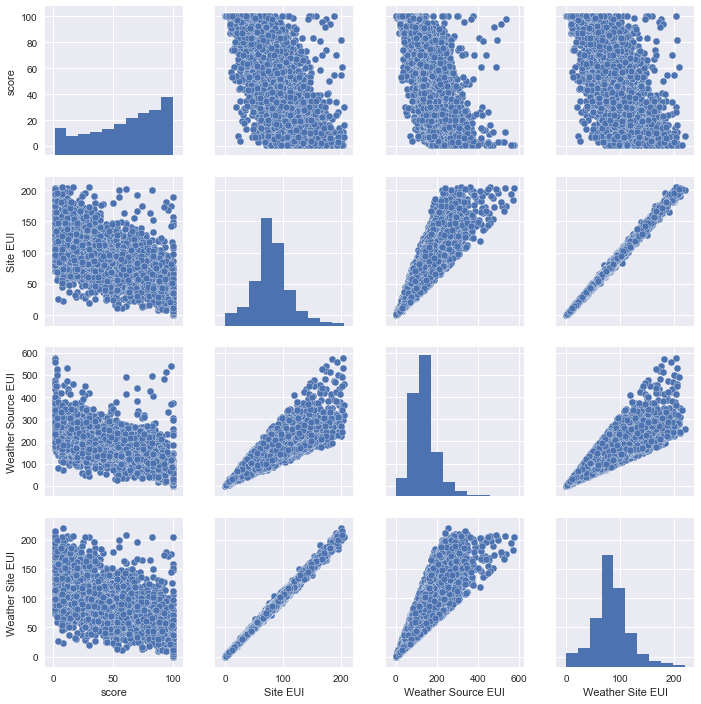

In [108]:
filtered_df=transformed_df[['score','Site EUI','Weather Source EUI','Weather Site EUI']]
filtered_df.dropna(inplace=True)
sns.set()
cols=list(filtered_df.columns)
sns.pairplot(filtered_df,size=2.5)
plt.show()

In [109]:
# Copy the original data
transformed_df = data.copy()

# Select the numeric columns
numeric_subset = data.select_dtypes('number')

# Create columns with log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'score':
        next
    else:
        numeric_subset['log_' + col] = np.log(numeric_subset[col])
        
# Select the categorical columns
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
transformed_df = pd.concat([numeric_subset, categorical_subset], axis = 1)

transformed_df.shape

C:\Users\gaurav.singh.rawal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
C:\Users\gaurav.singh.rawal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


(11319, 110)

In [110]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    
    # Dont want to remove correlations between Energy Star Score
    y = x['score']
    x = x.drop(columns = ['score'])
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    x = x.drop(columns = ['Weather Normalized Site EUI (kBtu/ft²)', 
                          'Water Use (All Water Sources) (kgal)',
                          'log_Water Use (All Water Sources) (kgal)',
                          'Largest Property Use Type - Gross Floor Area (ft²)'])
    
    # Add the score back in to the data
    x['score'] = y
               
    return x

In [111]:
# Remove the collinear features above a specified correlation coefficient
transformed_df = remove_collinear_features(transformed_df, 0.6);

C:\Users\gaurav.singh.rawal\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal


In [112]:
# Remove any columns with all na values
transformed_df  = transformed_df.dropna(axis=1, how = 'all')
transformed_df.shape

(11319, 65)

In [113]:
# Extract the buildings with no score and the buildings with a score
no_score = transformed_df[transformed_df['score'].isna()]
transformed_df = transformed_df[transformed_df['score'].notnull()]
transformed_df.head(15)

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,...,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility,score
12,15,2637863,NaN,1903,2,100,32.0,7.5,0.0,51.01,NaN,NaN,NaN,NaN,5.015954,3.932022,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,93.0
18,21,2780056,NaN,1939,2,100,76.2,3.5,0.0,18.40,NaN,NaN,NaN,NaN,7.329815,2.912351,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72.0
19,22,4988574,179130.0,1939,1,100,75.7,4.0,0.0,NaN,40.857943,-73.934962,12.0,281.0,6.842150,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,67.0
20,23,4988569,102150.0,1939,1,100,77.1,2.6,0.0,NaN,40.858256,-73.934734,12.0,281.0,6.377747,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80.0
21,24,2806486,NaN,1911,2,100,68.0,6.1,0.5,NaN,NaN,NaN,NaN,NaN,6.163315,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100.0
22,25,4988686,151666.0,1911,1,100,23.7,6.8,NaN,NaN,40.773465,-73.962116,8.0,130.0,-inf,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100.0
23,26,4988688,64827.0,1911,1,100,17.9,4.8,0.0,4.22,40.773843,-73.961838,8.0,130.0,1.163151,1.439835,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100.0
30,33,3111973,175885.0,1973,2,100,56.2,10.7,0.2,1.35,40.786238,-73.939958,11.0,162.0,5.314191,0.300105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40.0
31,34,3129181,167856.0,1952,4,100,49.5,7.4,0.3,NaN,NaN,NaN,NaN,NaN,5.263208,NaN,0,0,0,0,0,0,0,0

In [114]:
transformed_df=transformed_df.replace([np.inf, -np.inf], np.nan)

In [115]:
# Create an imputer object with a median filling strategy
imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=1)

# Train on the training features and transform
base_df = pd.DataFrame(imputer.fit_transform(transformed_df))
base_df.columns = transformed_df.columns
base_df.index = transformed_df.index

In [116]:
base_df.head(20)

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,...,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility,score
12,15.0,2637863.0,0.0,1903.0,2.0,100.0,32.0,7.5,0.0,51.01,0.000000,0.000000,0.0,0.0,5.015954,3.932022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.0
18,21.0,2780056.0,0.0,1939.0,2.0,100.0,76.2,3.5,0.0,18.40,0.000000,0.000000,0.0,0.0,7.329815,2.912351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0
19,22.0,4988574.0,179130.0,1939.0,1.0,100.0,75.7,4.0,0.0,0.00,40.857943,-73.934962,12.0,281.0,6.842150,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0
20,23.0,4988569.0,102150.0,1939.0,1.0,100.0,77.1,2.6,0.0,0.00,40.858256,-73.934734,12.0,281.0,6.377747,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0
21,24.0,2806486.0,0.0,1911.0,2.0,100.0,68.0,6.1,0.5,0.00,0.000000,0.000000,0.0,0.0,6.163315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
22,25.0,4988686.0,151666.0,1911.0,1.0,100.0,23.7,6.8,0.0,0.00,40.773465,-73.962116,8.0,130.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [117]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(base_df)

# Transform both the training and testing data
scaled_base_df = scaler.transform(base_df)
# Train on the training features and transform
base_data = pd.DataFrame(imputer.fit_transform(scaled_base_df))
base_data.columns = base_df.columns
base_data.index = base_df.index


In [118]:
base_data.head(15)

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,...,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility,score
12,0.000000,0.439592,0.000000,0.723150,0.012903,1.0,0.156250,0.140449,0.000000,0.002352,0.000000,1.000000,0.000000,0.000000,0.547770,0.564458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.929293
18,0.000401,0.463355,0.000000,0.809069,0.012903,1.0,0.372070,0.065543,0.000000,0.000848,0.000000,1.000000,0.000000,0.000000,0.720955,0.491082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.717172
19,0.000467,0.832429,0.013230,0.809069,0.006452,1.0,0.369629,0.074906,0.000000,0.000000,0.998657,0.003973,0.214286,0.002389,0.684455,0.281509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667
20,0.000534,0.832428,0.007544,0.809069,0.006452,1.0,0.376465,0.048689,0.000000,0.000000,0.998665,0.003976,0.214286,0.002389,0.649696,0.281509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.797980
21,0.000601,0.467772,0.000000,0.742243,0.012903,1.0,0.332031,0.114232,0.263158,0.000000,0.000000,1.000000,0.000000,0.000000,0.633646,0.281509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [135]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV,cross_val_predict,cross_val_score

def generate_hp_list(model):
    '''np.random.seed(123)
    C_range = np.random.normal(1, 0.2, 10).astype(float)

    # Check that C>0 
    C_range[C_range < 0] = 0.0001'''
    C_range=[0.1,1,0.001,0.0001,10,1000]
    max_iter=[100,500,1000,1500,2000]
    loss = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
    penalty = ['l1', 'l2', 'elasticnet']
    alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive']
    class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
    if isinstance(model,LinearRegression):
        param_grid={'normalize':[True,False],'fit_intercept':[True,False],'n_jobs':[None,100,200,300,400,500]}
    if isinstance(model,Lasso):
        param_grid={'alpha':alpha,'normalize':[True,False],'fit_intercept':[True,False]}
    if isinstance(model,Ridge):
        param_grid={'alpha':alpha,'normalize':[True,False],'fit_intercept':[True,False]}
    '''if isinstance(model,ElasticNet):
        param_grid={'kernel': ['linear', 'rbf'],'gamma':[0,10,100],'C':[1,10,100,1000]}'''
    if isinstance(model,DecisionTreeRegressor):
        param_grid = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
         'min_samples_split': [2, 5, 10],
         'min_samples_leaf': [1, 2, 4],
         'max_features': ['auto', 'sqrt']}
    if isinstance(model,RandomForestRegressor):
        param_grid = {'bootstrap': [True, False],
         'max_depth': [5,10,15,20,25],
         'max_features': ['auto', 'sqrt'],
         'min_samples_leaf': [2,3,4],
         'min_samples_split': [2,3,4],
         'n_estimators': [50,100,200,300,400,500]}
    if isinstance(model,GradientBoostingRegressor):
        param_grid = {'learning_rate': [0.01,0.025,0.05],
         'subsample':[0.5],
         'max_depth':[2,3,4,5],
         'n_estimators': [25,50,100]}
    return param_grid  

In [120]:
def hyperparameter_tuner(model,train_data,features,target,hp_list):
    
    hp_perf=[]
    model_cv=RandomizedSearchCV(model,param_distributions=hp_list,cv=5,n_jobs=-1)
    model_cv.fit(train_data[features],train_data[target])
    best_param=model_cv.best_params_
    best_score=model_cv.best_score_  
   
    return model_cv, best_param, best_score

In [121]:
def train_model(model,hyperparams,data,features,target):
        model.fit(data[features],data[target])
        return model

In [122]:
from sklearn import metrics
def evaluate_model(model,bestparams,train_data,train_cols,target,val_data):
    if isinstance(model,LinearRegression):
        print("Evaluating Linear Regression *****************")
        linreg = LinearRegression()
        linreg.set_params(**bestparams.best_params_)
        linreg.fit(train_data[train_cols],train_data[target])
        val_predict=linreg.predict(val_data[train_cols])
        mae_error=mean_absolute_error(val_data[target],val_predict)
        print("Mean Error for Logreg:",mae_error)
        return linreg,mae_error
    if isinstance(model,Lasso):
        print("Evaluating Lasso Regession *********************")
        lassoreg = Lasso()
        lassoreg.set_params(**bestparams.best_params_)
        lassoreg.fit(train_data[train_cols],train_data[target])
        val_predict=lassoreg.predict(val_data[train_cols])
        mae_error=mean_absolute_error(val_data[target],val_predict)
        print("Mean Error for Lasso:",mae_error)
        return lassoreg,mae_error
    if isinstance(model,Ridge):
        print("Evaluating Ridge Regression*********************")
        ridgereg = Ridge()
        ridgereg.set_params(**bestparams.best_params_)
        ridgereg.fit(train_data[train_cols],train_data[target])
        val_predict=ridgereg.predict(val_data[train_cols])
        mae_error=mean_absolute_error(val_data[target],val_predict)
        print("Mean Error for Ridge:",mae_error)
        return ridgereg,mae_error
    if isinstance(model,ElasticNet):
        print("Evaluating Elastic Net *********************")
        enetreg = ElasticNet()
        enetreg.set_params(**bestparams.best_params_)
        enetreg.fit(train_data[train_cols],train_data[target])
        val_predict=enetreg.predict(val_data[train_cols])
        mae_error=mean_absolute_error(val_data[target],val_predict)
        print("Mean Error for Elastic Net:",mae_error)
        return enetreg,mae_error
    if isinstance(model,GradientBoostingRegressor):
        print("Evaluating Gradient Boosting *********************")
        gbm = GradientBoostingRegressor()
        gbm.set_params(**bestparams.best_params_)
        gbm.fit(train_data[train_cols],train_data[target])
        val_predict=gbm.predict(val_data[train_cols])
        mae_error=mean_absolute_error(val_data[target],val_predict)
        print("Mean Error for GBM:",mae_error)
        return gbm,mae_error
    if isinstance(model,DecisionTreeRegressor):
        print("Evaluating Decision Trees *********************")
        dtree = DecisionTreeRegressor()
        dtree.set_params(**bestparams.best_params_)
        dtree.fit(train_data[train_cols],train_data[target])
        val_predict=dtree.predict(val_data[train_cols])
        mae_error=mean_absolute_error(val_data[target],val_predict)
        print("Mean Error for Decision Tree:",mae_error)
        return dtree,mae_error
    if isinstance(model,RandomForestRegressor):
        print("Evaluating Random Forest *********************")
        rforest = RandomForestRegressor()
        rforest.set_params(**bestparams.best_params_)
        rforest.fit(train_data[train_cols],train_data[target])
        val_predict=rforest.predict(val_data[train_cols])
        mae_error=mean_absolute_error(val_data[target],val_predict)
        print("Mean Error for Random Forest:",mae_error)
        return rforest,mae_error


In [123]:
train_data,test_data=train_test_split(base_data,test_size=0.3,random_state=42)


In [124]:
def train_base_learners(train_data, model):
    best_models=[]
    model_perf=[]
    hp_perf=[]
    train_columns=train_data.columns
    features=train_columns.drop('score')
    target='score'

    train_df, test_df=train_test_split(train_data,test_size=0.3,random_state=42)
    #traindata,valdata=train_test_split(transformed_data,test_size=0.3,random_state=42)
    print('Fetching Hyper Parameters *********')
    hp_list=generate_hp_list(model)
    bestmodelparams, bestparams, bestscore=hyperparameter_tuner(model,train_df,features,target,hp_list)
    #best_train_model=train_model(model,bestparams,traindata,features,target)
    print('Starting Model Evaluation *********')
    best_model, best_result=evaluate_model(model,bestmodelparams,train_df,features,target,test_df)
    best_models.append(best_model)
    model_perf.append(best_result)
    hp_perf.append(bestparams)
    best_mf=best_models[model_perf.index(max(model_perf))]
    best_hp=hp_perf[model_perf.index(max(model_perf))]
    best_model=train_model(best_mf,best_hp,pd.concat([train_df,test_df]),features,target)
    return(best_mf,best_hp,best_result,best_model)

In [125]:
lreg=LinearRegression()
lassoreg=Lasso(random_state=True)
ridgereg=Ridge()
elsnet=ElasticNet()
dtree=DecisionTreeRegressor()
rforest=RandomForestRegressor()
gbm=GradientBoostingRegressor()

In [126]:
models_score={}
best_models=[]
print(lreg.get_params)
model, hparams, result, best_model=train_base_learners(train_data, lreg)
best_models.append(best_model)
models_score['lreg']=result
print(models_score)

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)>
Fetching Hyper Parameters *********
Starting Model Evaluation *********
Evaluating Linear Regression *****************
Mean Error for Logreg: 0.13668121851978343
{'lreg': 0.13668121851978343}


In [127]:
print(lassoreg.get_params)
model, hparams, result, best_model=train_base_learners(train_data, lassoreg)
best_models.append(best_model)
models_score['lassoreg']=result
print(models_score)

<bound method BaseEstimator.get_params of Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=True,
   selection='cyclic', tol=0.0001, warm_start=False)>
Fetching Hyper Parameters *********
Starting Model Evaluation *********
Evaluating Lasso Regession *********************
Mean Error for Lasso: 0.13691471929294666
{'lreg': 0.13668121851978343, 'lassoreg': 0.13691471929294666}


In [128]:
print(ridgereg.get_params)
model, hparams, result, best_model=train_base_learners(train_data, ridgereg)
best_models.append(best_model)
models_score['ridgereg']=result
print(models_score)

<bound method BaseEstimator.get_params of Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)>
Fetching Hyper Parameters *********
Starting Model Evaluation *********
Evaluating Ridge Regression*********************
Mean Error for Ridge: 0.136688001094238
{'lreg': 0.13668121851978343, 'lassoreg': 0.13691471929294666, 'ridgereg': 0.136688001094238}


In [129]:
print(dtree.get_params)
model, hparams, result, best_model=train_base_learners(train_data, dtree)
best_models.append(best_model)
models_score['dtree']=result
print(models_score)

<bound method BaseEstimator.get_params of DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')>
Fetching Hyper Parameters *********
Starting Model Evaluation *********
Evaluating Decision Trees *********************
Mean Error for Decision Tree: 0.11411772957333784
{'lreg': 0.13668121851978343, 'lassoreg': 0.13691471929294666, 'ridgereg': 0.136688001094238, 'dtree': 0.11411772957333784}


In [130]:
print(rforest.get_params)
model, hparams, result, best_model=train_base_learners(train_data, rforest)
best_models.append(best_model)
models_score['rforest']=result
print(models_score)

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)>
Fetching Hyper Parameters *********
Starting Model Evaluation *********
Evaluating Random Forest *********************
Mean Error for Random Forest: 0.09670151229452655
{'lreg': 0.13668121851978343, 'lassoreg': 0.13691471929294666, 'ridgereg': 0.136688001094238, 'dtree': 0.11411772957333784, 'rforest': 0.09670151229452655}


In [131]:
print(gbm.get_params)
model, hparams, result, best_model=train_base_learners(train_data, gbm)
best_models.append(best_model)
models_score['gbm']=result
print(models_score)

<bound method BaseEstimator.get_params of GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)>
Fetching Hyper Parameters *********
Starting Model Evaluation *********
Evaluating Gradient Boosting *********************
Mean Error for GBM: 0.11092531996655959
{'lreg': 0.13668121851978343, 'lassoreg': 0.13691471929294666, 'ridgereg': 0.136688001094238, 'dtree': 0.11411772957333784, 'rforest': 0.09670151229452655, 'gbm': 0.11092531996655959}


In [140]:
from vecstack import stacking
train_columns=train_data.columns
features=train_columns.drop('score')
target='score'

S_train, S_test = stacking(best_models,train_data[features],train_data[target],test_data[features],regression=True,needs_proba=False,
         mode='oof_pred_bag',save_dir=None, metric=mean_absolute_error, n_folds=5, stratified=True, shuffle=True,random_state=10,verbose=2)

C:\Users\gaurav.singh.rawal\AppData\Local\Continuum\anaconda3\lib\site-packages\vecstack\core.py:459: UserWarning: This is regression task hence classification-specific parameters set to <True> were ignored: <stratified>
  warnings.warn(warn_str, UserWarning)


task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [6]

model  0:     [LinearRegression]
    fold  0:  [0.13528421]
    fold  1:  [0.13574117]
    fold  2:  [0.13536551]
    fold  3:  [0.13773990]
    fold  4:  [0.13511712]
    ----
    MEAN:     [0.13584958] + [0.00096701]
    FULL:     [0.13584948]

model  1:     [Lasso]
    fold  0:  [0.13545254]
    fold  1:  [0.13647508]
    fold  2:  [0.13570132]
    fold  3:  [0.13839982]
    fold  4:  [0.13601795]
    ----
    MEAN:     [0.13640934] + [0.00105226]
    FULL:     [0.13640920]

model  2:     [Ridge]
    fold  0:  [0.13528644]
    fold  1:  [0.13577203]
    fold  2:  [0.13545038]
    fold  3:  [0.13774718]
    fold  4:  [0.13518125]
    ----
    MEAN:     [0.13588746] + [0.00095109]
    FULL:     [0.13588735]

model  3:     [DecisionTreeRegressor]
    fold  0:  [0.11162236]
    fold  1:  [0.11304673]
    fold  2:  [0.11138454]
    fold  3:  [0.11228742]
    fold  4:  [0.1097165

In [139]:
meta_learner_xgb = XGBRegressor(random_state=0, n_jobs=-1, learning_rate=0.1, 
                      n_estimators=100, max_depth=3)

model = meta_learner_xgb.fit(S_train, train_data[target])
#y_pred = model.predict(S_test)
y_pred = model.predict(S_test)
print('Final prediction score: [%.8f]' % mean_absolute_error(test_data[target], y_pred))

C:\Users\gaurav.singh.rawal\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\gaurav.singh.rawal\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[14:03:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Final prediction score: [0.09471170]
